# Testing Naive Batch Learning

Версия вторая: параллельные игры с уменьшающимся списком
- вместо одной среды теперь будет список сред (игр) длины `play_batch_size`, с каждой из них собрать список состояний и подать на вход `agent.act` как батч; обновить список после завершения всех игр
- плюс: баланс опыта и обучения
- плюс: быстро (из-за `agent.act`)
- минус: `agent.act` получает батчи разного размера если завершилась только часть игр
- плюс: не нужно переписывать `Trainer.train`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp -a -n /content/drive/MyDrive/wordle-rl/. /content/

In [3]:
! mkdir /content/drive/MyDrive/wordle-rl/tests

In [4]:
! pip install cpprb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.8 MB/s eta 0:00:00


In [5]:
%load_ext autoreload
%autoreload 2

from functools import partial
from collections import defaultdict
import pickle

from wordle.wordlenp import Wordle
from environment.environment import Environment, StateYesNo, StateVocabulary, ActionVocabulary
from dqn.cpprb_agent import Agent
from dqn.train import Trainer
from replay_buffer.cpprb import PrioritizedReplayBuffer, ReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import torch
import numpy as np
np.random.seed(0)

## Датасеты

In [6]:
word_list = Wordle._load_vocabulary('wordle/guesses.txt', astype=np.array)

def make_data(n_answers, n_guesses):
    guesses = np.random.choice(word_list, size=n_guesses, replace=False)
    answers = np.random.choice(guesses, size=n_answers, replace=False)
    return answers, guesses

### 10 answers, 100 guesses

In [7]:
answers_10_100, guesses_10_100 = make_data(10, 100)
print(answers_10_100)

['abmho' 'cites' 'aware' 'blays' 'acker' 'rawin' 'anile' 'eorls' 'feers'
 'sadza']


### 100 answers, 100 guesses

In [8]:
answers_100_100, guesses_100_100 = make_data(100, 100)
print(answers_100_100)

['lilac' 'orles' 'twirl' 'unled' 'sings' 'grind' 'sheaf' 'benny' 'slews'
 'karst' 'rimus' 'lossy' 'joker' 'leash' 'scopa' 'viols' 'giron' 'raiks'
 'lummy' 'renig' 'tinds' 'infos' 'logon' 'drill' 'gudes' 'ammon' 'bhoot'
 'hurry' 'noils' 'coven' 'beryl' 'margs' 'sorbo' 'momes' 'scald' 'potch'
 'flows' 'torus' 'prill' 'scuts' 'brith' 'tamin' 'sewar' 'joram' 'aldol'
 'hazel' 'texes' 'sibbs' 'truth' 'spoil' 'hames' 'actin' 'maces' 'rayas'
 'thuya' 'sugan' 'felly' 'newsy' 'bolos' 'mimeo' 'chems' 'dicty' 'liefs'
 'scuff' 'burps' 'abyes' 'zones' 'cuspy' 'kerve' 'haith' 'amino' 'zygal'
 'kokum' 'zambo' 'icier' 'piers' 'sambo' 'laden' 'barge' 'solei' 'mauts'
 'groat' 'pearl' 'curse' 'jujus' 'troop' 'bilge' 'sibyl' 'gassy' 'elain'
 'daube' 'feyly' 'duals' 'hoper' 'hains' 'beige' 'poove' 'miffy' 'lesbo'
 'dawds']


### 50 answers, 200 guesses

In [9]:
answers_50_200, guesses_50_200 = make_data(50, 200)
print(answers_50_200)

['toran' 'burka' 'umpie' 'brock' 'civic' 'beige' 'hoiks' 'biffo' 'nagas'
 'sheol' 'malls' 'matzo' 'peeve' 'deshi' 'mooli' 'scaud' 'ameba' 'wadds'
 'bayts' 'glees' 'kaput' 'bitos' 'comae' 'dosed' 'rabis' 'neats' 'tutti'
 'stays' 'smoky' 'chase' 'resaw' 'simas' 'sowne' 'rorid' 'rebec' 'deawy'
 'hinny' 'sores' 'cerge' 'yogas' 'fouet' 'wheel' 'sowfs' 'talus' 'yabas'
 'topee' 'sabin' 'unbox' 'dyers' 'qophs']


### 300 answers, 300 guesses

In [10]:
answers_300_300, guesses_300_300 = make_data(300, 300)
print(answers_300_300)

['hoied' 'aarti' 'dyers' 'ingot' 'hasty' 'tices' 'tache' 'deoxy' 'sutta'
 'score' 'fiefs' 'sling' 'ready' 'wests' 'dobes' 'tells' 'bitts' 'roper'
 'veena' 'hewer' 'chats' 'jarta' 'ceric' 'olent' 'feare' 'bodge' 'fleer'
 'prats' 'spiny' 'tryps' 'welts' 'march' 'jelly' 'furor' 'okapi' 'penni'
 'curve' 'altar' 'aboon' 'salut' 'amido' 'razor' 'vouch' 'prill' 'ganev'
 'dukka' 'noxal' 'briar' 'wills' 'trigo' 'dusts' 'meter' 'veale' 'hafiz'
 'dosha' 'wilis' 'ohmic' 'silds' 'giust' 'blimy' 'zerda' 'mucus' 'abrin'
 'nandu' 'larva' 'cruds' 'kaies' 'hussy' 'dolce' 'birch' 'madam' 'chase'
 'onely' 'molys' 'scape' 'sauce' 'amate' 'mohur' 'vagal' 'royne' 'spics'
 'azuki' 'acres' 'shops' 'sicks' 'sunup' 'cosey' 'louse' 'aweel' 'skosh'
 'twoer' 'loves' 'wents' 'reest' 'winna' 'rosed' 'mbira' 'rangy' 'omega'
 'moira' 'typey' 'romal' 'bachs' 'floss' 'scath' 'roast' 'moola' 'moles'
 'witch' 'rabbi' 'chest' 'aulos' 'yokes' 'aspen' 'sepic' 'lirot' 'lemon'
 'musts' 'drouk' 'kudzu' 'yacka' 'sonny' 'hived' 'l

### 100 answers, 2000 guesses

In [11]:
answers_100_2000, guesses_100_2000 = make_data(100, 2000)
print(answers_100_2000)

['fumed' 'rival' 'zizit' 'wests' 'scrog' 'gryce' 'seils' 'sugar' 'glims'
 'pharm' 'pyets' 'kilts' 'bings' 'emyde' 'duads' 'shahs' 'spaza' 'spore'
 'redub' 'sidas' 'choco' 'woofs' 'sukuk' 'spumy' 'mirex' 'sluse' 'tween'
 'nodus' 'wands' 'unled' 'rates' 'toxin' 'lotes' 'wacko' 'ariot' 'baisa'
 'sways' 'roads' 'poked' 'popsy' 'gonif' 'vutty' 'bicep' 'parky' 'braid'
 'ports' 'spyal' 'match' 'spook' 'scowp' 'sdein' 'lovie' 'torii' 'souks'
 'vibey' 'genny' 'clues' 'decaf' 'diced' 'delay' 'mirly' 'flogs' 'lotos'
 'whine' 'seems' 'jerry' 'scram' 'gosse' 'roped' 'pipis' 'spank' 'seder'
 'doorn' 'evict' 'buteo' 'ponks' 'miffy' 'potin' 'rathe' 'papaw' 'local'
 'tolus' 'apode' 'jouks' 'decad' 'temes' 'wafts' 'liter' 'kagos' 'piste'
 'ogmic' 'fyles' 'brace' 'adage' 'hepar' 'bales' 'molal' 'eject' 'seles'
 'commy']


## Plotting Utility

In [12]:
def plot_results(tasks_results, figname):
    n_tasks = len(tasks_results)
    _, ax = plt.subplots(1, n_tasks, figsize=(4*n_tasks, 5))
    
    color = ['b','g','r','c','m','y','k','w']

    # over tasks
    for i, (task_name, results) in enumerate(tasks_results.items()):
        # over methods
        for c, (method_name, res) in enumerate(results.items()):
            train_timers, train_win_rates, test_timers, test_win_rates = res
            ax[i].plot(train_timers, train_win_rates, label=method_name+' (train)', c=color[c], alpha=0.2)
            ax[i].plot(test_timers, test_win_rates, label=method_name+' (test)', c=color[c])
        ax[i].set_xlabel('time, s')
        ax[i].set_ylabel('win rate, s')
        ax[i].legend()
        ax[i].set_title(task_name)
    plt.savefig(figname + '.svg', bbox_inches='tight')
    plt.show()

## Sampling

In [13]:
soft_rewards = {'B':1, 'Y':2, 'G':3, 'win':20, 'lose':-10, 'step':-4}
hard_rewards = {'B':0, 'Y':0, 'G':0, 'win':10, 'lose':-10, 'step':-2}
step_rewards = {'B':0, 'Y':1, 'G':1, 'win':10, 'lose':-10, 'step':-5}
char_rewards = {'B':0, 'Y':1, 'G':1, 'win':10, 'lose':-10, 'step':-2}

In [14]:
tasks_results = defaultdict(dict)

### Uniform

In [15]:
def experiment(answers, guesses, play_batch_size, n_batches, n_batches_warm):
    env_list = []
    for _ in range(play_batch_size):
        env = Environment(
            rewards=step_rewards,
            wordle=Wordle(vocabulary=guesses, answers=answers),
            state_instance=StateYesNo()
        )
        env_list.append(env)

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        # here is what we are experimenting with
        replay_buffer=ReplayBuffer(state_size=env.state.size),
    )

    trainer = Trainer(
        env_list, agent,
        play_batch_size=play_batch_size,
        n_batches=n_batches,
        n_batches_warm=n_batches_warm
    )
    
    res = trainer.train(eps_decay=0.9995, nickname=f'uniform-{len(answers)}-{len(guesses)}')
    return res

In [16]:
res = experiment(
    answers_10_100, guesses_10_100,
    play_batch_size=8,
    n_batches=500, n_batches_warm=15,
)

tasks_results['10/100']['uniform'] = res


Batch   62	Time: 5 s	Agent Eps: 0.97	Train Win Rate: 6.45%	Test Win Rate: 50.00%	Test Mean Steps: 2.40

Batch  124	Time: 7 s	Agent Eps: 0.94	Train Win Rate: 14.52%	Test Win Rate: 40.00%	Test Mean Steps: 1.75

Batch  186	Time: 9 s	Agent Eps: 0.91	Train Win Rate: 25.81%	Test Win Rate: 60.00%	Test Mean Steps: 2.33

Batch  248	Time: 11 s	Agent Eps: 0.88	Train Win Rate: 46.77%	Test Win Rate: 90.00%	Test Mean Steps: 2.67

Batch  310	Time: 12 s	Agent Eps: 0.86	Train Win Rate: 45.16%	Test Win Rate: 100.00%	Test Mean Steps: 2.00

Batch  372	Time: 14 s	Agent Eps: 0.83	Train Win Rate: 51.61%	Test Win Rate: 90.00%	Test Mean Steps: 2.22

Batch  434	Time: 15 s	Agent Eps: 0.80	Train Win Rate: 82.26%	Test Win Rate: 100.00%	Test Mean Steps: 2.00

Batch  496	Time: 16 s	Agent Eps: 0.78	Train Win Rate: 66.13%	Test Win Rate: 100.00%	Test Mean Steps: 2.10

Saving checkpoint... Saved to uniform-10-100-1.pth


In [17]:
res = experiment(
    answers_100_100, guesses_100_100,
    play_batch_size=8,
    n_batches=10000, n_batches_warm=5,
)

tasks_results['100/100']['uniform'] = res


Batch 1250	Time: 35 s	Agent Eps: 0.54	Train Win Rate: 30.64%	Test Win Rate: 25.00%	Test Mean Steps: 2.88

Batch 2500	Time: 66 s	Agent Eps: 0.29	Train Win Rate: 59.04%	Test Win Rate: 57.00%	Test Mean Steps: 2.70

Batch 3750	Time: 93 s	Agent Eps: 0.15	Train Win Rate: 79.28%	Test Win Rate: 76.00%	Test Mean Steps: 2.75

Batch 5000	Time: 114 s	Agent Eps: 0.08	Train Win Rate: 94.08%	Test Win Rate: 95.00%	Test Mean Steps: 2.57

Batch 6250	Time: 133 s	Agent Eps: 0.05	Train Win Rate: 98.08%	Test Win Rate: 98.00%	Test Mean Steps: 2.56

Batch 7500	Time: 151 s	Agent Eps: 0.05	Train Win Rate: 98.80%	Test Win Rate: 99.00%	Test Mean Steps: 2.53

Batch 8750	Time: 168 s	Agent Eps: 0.05	Train Win Rate: 98.40%	Test Win Rate: 99.00%	Test Mean Steps: 2.51

Batch 10000	Time: 186 s	Agent Eps: 0.05	Train Win Rate: 98.80%	Test Win Rate: 99.00%	Test Mean Steps: 2.54

Saving checkpoint... Saved to uniform-100-100-1.pth


In [18]:
# with open('sampling.pickle', 'wb') as handle:
#     pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [19]:
res = experiment(
    answers_300_300, guesses_300_300,
    play_batch_size=8,
    n_batches=20000, n_batches_warm=5,
)
tasks_results['300/300']['uniform'] = res


Batch 2500	Time: 72 s	Agent Eps: 0.29	Train Win Rate: 1.80%	Test Win Rate: 0.67%	Test Mean Steps: 2.00

Batch 5000	Time: 146 s	Agent Eps: 0.08	Train Win Rate: 5.92%	Test Win Rate: 6.67%	Test Mean Steps: 2.95

Batch 7500	Time: 216 s	Agent Eps: 0.05	Train Win Rate: 10.88%	Test Win Rate: 13.33%	Test Mean Steps: 3.08

Batch 10000	Time: 285 s	Agent Eps: 0.05	Train Win Rate: 22.52%	Test Win Rate: 21.33%	Test Mean Steps: 3.31

Batch 12500	Time: 351 s	Agent Eps: 0.05	Train Win Rate: 33.12%	Test Win Rate: 30.67%	Test Mean Steps: 3.53

Batch 15000	Time: 414 s	Agent Eps: 0.05	Train Win Rate: 46.96%	Test Win Rate: 44.33%	Test Mean Steps: 3.59

Batch 17500	Time: 471 s	Agent Eps: 0.05	Train Win Rate: 60.28%	Test Win Rate: 57.33%	Test Mean Steps: 3.39

Batch 20000	Time: 525 s	Agent Eps: 0.05	Train Win Rate: 70.24%	Test Win Rate: 71.33%	Test Mean Steps: 3.08

Saving checkpoint... Saved to uniform-300-300-1.pth


In [20]:
# with open('sampling.pickle', 'wb') as handle:
#     pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

cp: cannot stat '*.pickle': No such file or directory


In [21]:
res = experiment(
    answers_100_2000, guesses_100_2000,
    play_batch_size=8,
    n_batches=20000, n_batches_warm=15,
)
tasks_results['100/2000']['uniform'] = res

/content/dqn/train.py:311: RuntimeWarning: Mean of empty slice.
  mean_steps = steps[success.astype(bool)].mean()
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Batch 2500	Time: 78 s	Agent Eps: 0.29	Train Win Rate: 1.12%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch 5000	Time: 156 s	Agent Eps: 0.08	Train Win Rate: 2.52%	Test Win Rate: 2.00%	Test Mean Steps: 2.50

Batch 7500	Time: 228 s	Agent Eps: 0.05	Train Win Rate: 3.32%	Test Win Rate: 3.00%	Test Mean Steps: 2.67

Batch 10000	Time: 301 s	Agent Eps: 0.05	Train Win Rate: 9.84%	Test Win Rate: 8.00%	Test Mean Steps: 2.38

Batch 12500	Time: 372 s	Agent Eps: 0.05	Train Win Rate: 13.40%	Test Win Rate: 14.00%	Test Mean Steps: 2.93

Batch 15000	Time: 439 s	Agent Eps: 0.05	Train Win Rate: 25.60%	Test Win Rate: 27.00%	Test Mean Steps: 2.67

Batch 17500	Time: 502 s	Agent Eps: 0.05	Train Win Rate: 37.96%	Test Win Rate: 41.00%	Test Mean Steps: 2.49

Batch 20000	Time: 563 s	Agent Eps: 0.05	Train Win Rate: 45.40%	Test Win Rate: 44.00%	Test Mean Steps: 2.57

Saving checkpoint... Saved to uniform-100-2000-1.pth


In [22]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### A Little Prioritized

In [23]:
def experiment(answers, guesses, play_batch_size, n_batches, n_batches_warm):
    env_list = []
    for _ in range(play_batch_size):
        env = Environment(
            rewards=step_rewards,
            wordle=Wordle(vocabulary=guesses, answers=answers),
            state_instance=StateYesNo()
        )
        env_list.append(env)

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        # here is what we are experimenting with
        replay_buffer=PrioritizedReplayBuffer(
            state_size=env.state.size,
            alpha=0.1, beta=1, beta_growth_rate=1,
        )
    )

    trainer = Trainer(
        env_list, agent,
        play_batch_size=play_batch_size,
        n_batches=n_batches,
        n_batches_warm=n_batches_warm
    )
    
    res = trainer.train(eps_decay=0.9995, nickname=f'little-{len(answers)}-{len(guesses)}')
    return res

In [24]:
res = experiment(
    answers_10_100, guesses_10_100,
    play_batch_size=8,
    n_batches=500, n_batches_warm=15,
)

tasks_results['10/100']['little'] = res


Batch   62	Time: 2 s	Agent Eps: 0.97	Train Win Rate: 1.61%	Test Win Rate: 30.00%	Test Mean Steps: 1.67

Batch  124	Time: 4 s	Agent Eps: 0.94	Train Win Rate: 16.13%	Test Win Rate: 30.00%	Test Mean Steps: 1.67

Batch  186	Time: 6 s	Agent Eps: 0.91	Train Win Rate: 19.35%	Test Win Rate: 80.00%	Test Mean Steps: 2.75

Batch  248	Time: 8 s	Agent Eps: 0.88	Train Win Rate: 25.81%	Test Win Rate: 70.00%	Test Mean Steps: 2.00

Batch  310	Time: 9 s	Agent Eps: 0.86	Train Win Rate: 45.16%	Test Win Rate: 80.00%	Test Mean Steps: 2.12

Batch  372	Time: 10 s	Agent Eps: 0.83	Train Win Rate: 46.77%	Test Win Rate: 100.00%	Test Mean Steps: 2.30

Batch  434	Time: 12 s	Agent Eps: 0.80	Train Win Rate: 61.29%	Test Win Rate: 100.00%	Test Mean Steps: 1.90

Batch  496	Time: 13 s	Agent Eps: 0.78	Train Win Rate: 72.58%	Test Win Rate: 100.00%	Test Mean Steps: 2.20

Saving checkpoint... Saved to little-10-100-1.pth


In [25]:
res = experiment(
    answers_100_100, guesses_100_100,
    play_batch_size=8,
    n_batches=10000, n_batches_warm=5,
)

tasks_results['100/100']['little'] = res


Batch 1250	Time: 36 s	Agent Eps: 0.54	Train Win Rate: 27.36%	Test Win Rate: 33.00%	Test Mean Steps: 2.79

Batch 2500	Time: 67 s	Agent Eps: 0.29	Train Win Rate: 55.04%	Test Win Rate: 58.00%	Test Mean Steps: 2.83

Batch 3750	Time: 94 s	Agent Eps: 0.15	Train Win Rate: 77.60%	Test Win Rate: 74.00%	Test Mean Steps: 2.64

Batch 5000	Time: 118 s	Agent Eps: 0.08	Train Win Rate: 87.76%	Test Win Rate: 87.00%	Test Mean Steps: 2.62

Batch 6250	Time: 138 s	Agent Eps: 0.05	Train Win Rate: 96.56%	Test Win Rate: 95.00%	Test Mean Steps: 2.58

Batch 7500	Time: 157 s	Agent Eps: 0.05	Train Win Rate: 96.96%	Test Win Rate: 95.00%	Test Mean Steps: 2.58

Batch 8750	Time: 174 s	Agent Eps: 0.05	Train Win Rate: 99.52%	Test Win Rate: 99.00%	Test Mean Steps: 2.58

Batch 10000	Time: 192 s	Agent Eps: 0.05	Train Win Rate: 99.92%	Test Win Rate: 100.00%	Test Mean Steps: 2.53

Saving checkpoint... Saved to little-100-100-1.pth


In [26]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

In [27]:
res = experiment(
    answers_300_300, guesses_300_300,
    play_batch_size=8,
    n_batches=20000, n_batches_warm=5,
)
tasks_results['300/300']['little'] = res


Batch 2500	Time: 74 s	Agent Eps: 0.29	Train Win Rate: 2.80%	Test Win Rate: 1.00%	Test Mean Steps: 2.00

Batch 5000	Time: 149 s	Agent Eps: 0.08	Train Win Rate: 4.52%	Test Win Rate: 3.67%	Test Mean Steps: 3.00

Batch 7500	Time: 221 s	Agent Eps: 0.05	Train Win Rate: 9.28%	Test Win Rate: 10.00%	Test Mean Steps: 2.77

Batch 10000	Time: 292 s	Agent Eps: 0.05	Train Win Rate: 19.44%	Test Win Rate: 16.00%	Test Mean Steps: 3.06

Batch 12500	Time: 361 s	Agent Eps: 0.05	Train Win Rate: 35.16%	Test Win Rate: 31.00%	Test Mean Steps: 3.39

Batch 15000	Time: 424 s	Agent Eps: 0.05	Train Win Rate: 49.72%	Test Win Rate: 45.67%	Test Mean Steps: 3.44

Batch 17500	Time: 482 s	Agent Eps: 0.05	Train Win Rate: 60.92%	Test Win Rate: 63.00%	Test Mean Steps: 3.20

Batch 20000	Time: 538 s	Agent Eps: 0.05	Train Win Rate: 71.28%	Test Win Rate: 69.33%	Test Mean Steps: 3.01

Saving checkpoint... Saved to little-300-300-1.pth


In [28]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

In [29]:
res = experiment(
    answers_100_2000, guesses_100_2000,
    play_batch_size=8,
    n_batches=20000, n_batches_warm=5,
)
tasks_results['100/2000']['little'] = res


Batch 2500	Time: 76 s	Agent Eps: 0.29	Train Win Rate: 1.76%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch 5000	Time: 152 s	Agent Eps: 0.08	Train Win Rate: 1.88%	Test Win Rate: 2.00%	Test Mean Steps: 2.00

Batch 7500	Time: 227 s	Agent Eps: 0.05	Train Win Rate: 2.56%	Test Win Rate: 3.00%	Test Mean Steps: 2.33

Batch 10000	Time: 302 s	Agent Eps: 0.05	Train Win Rate: 2.96%	Test Win Rate: 2.00%	Test Mean Steps: 3.50

Batch 12500	Time: 377 s	Agent Eps: 0.05	Train Win Rate: 2.96%	Test Win Rate: 1.00%	Test Mean Steps: 4.00

Batch 15000	Time: 451 s	Agent Eps: 0.05	Train Win Rate: 3.40%	Test Win Rate: 2.00%	Test Mean Steps: 2.50

Batch 17500	Time: 526 s	Agent Eps: 0.05	Train Win Rate: 5.88%	Test Win Rate: 5.00%	Test Mean Steps: 3.80

Batch 20000	Time: 600 s	Agent Eps: 0.05	Train Win Rate: 5.96%	Test Win Rate: 4.00%	Test Mean Steps: 3.25

Saving checkpoint... Saved to little-100-2000-1.pth


In [30]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Plot Results

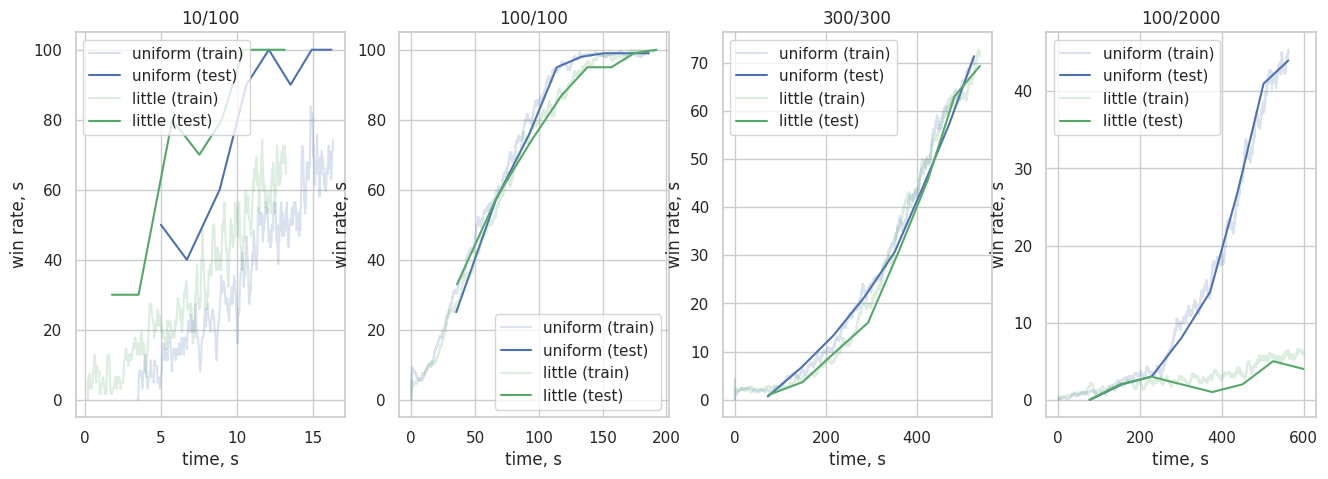

In [31]:
plot_results(tasks_results, 'sampling')